In [ ]:
%load_ext autoreload 
%autoreload 2

In [1]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

import time
from tqdm import tqdm
from itertools import combinations_with_replacement

In [2]:
import sys
import os
sys.path.append(os.path.dirname('../.'))

from scripts.load_and_save import (get_dcm_info, get_dcm_vol, vox_size2affine,
                                   load_nii_vol, save_vol_as_nii, raw2nifti)
from scripts.utils import print_img, print_imgs
from scripts.hessian_based import hessian_detect_2016

from ml.utils import get_total_params, load_pretrainned, test_model
from ml.controller import Controller
from ml.tio_dataset import TioDataset
from ml.metrics import (DICE_Metric, JAC_Metric, SN_Metric, SP_Metric,
                        IOU_Metric, ExponentialLogarithmicLoss)

from ml.models.HessNet import HessBlock, HessNet, HessNet2
from ml.models.unet3d import U_Net


In [3]:
PATCH_SIZE = 3*(64,)
DEVICE = 'cuda'

In [8]:
train_settings  = {
    "patch_shape" : PATCH_SIZE,
    "patches_per_volume" : 64,
    "patches_queue_length" : 1440,
    "batch_size" : 32,
    "num_workers": 4,
    "sampler": "uniform",#"weighted"
}

val_settings  = {
    "patch_shape" : PATCH_SIZE,
    "patches_per_volume" : 32,
    "patches_queue_length" : 1440,
    "batch_size" : 32,
    "num_workers": 4,
    "sampler": "uniform",#"weighted" #"uniform",#
}

test_settings  = {
    "patch_shape" : (192, 192, 64),
    "overlap_shape" : (24, 24, 24),
    "batch_size" : 4,
    "num_workers": 4,
}

data_dir = "/home/msst/Documents/medtech/data/HessData"
dataset = TioDataset(data_dir,
                 train_settings=train_settings,
                 val_settings=None,#val_settings,
                 test_settings=test_settings)

In [9]:
model = HessNet(start_scale=1, device=DEVICE)
#model = U_Net(channels=8)
print("total_params:", get_total_params(model))

total_params: 2366


In [10]:
controller_config = {
    "loss" : ExponentialLogarithmicLoss(gamma_tversky=0.5, gamma_bce=0.5, lamb=0.5, freq = 0.1, tversky_alfa=0.5),
    "metric" : DICE_Metric(),
    'device' : DEVICE,
    "model" : model,
    "optimizer_fn" : lambda model: torch.optim.Adam(model.parameters(), lr=0.005),
    "sheduler_fn": lambda optimizer: StepLR(optimizer, step_size=10, gamma=0.5)
}
controller = Controller(controller_config)

cuda


In [11]:
controller.fit(dataset, 50)

Epoch 1/50


100%|███████████████████████████████████████████| 24/24 [00:18<00:00,  1.31it/s]


{'mean_loss': 1.1392462725440662}


100%|█████████████████████████████████████████████| 5/5 [00:10<00:00,  2.12s/it]


{'metrics': [{'sample': 'IXI117_2', 'metric1': tensor([0.5723])}, {'sample': 'IXI117_0', 'metric1': tensor([0.4888])}, {'sample': 'IXI131_2', 'metric1': tensor([0.5847])}, {'sample': 'IXI131_0', 'metric1': tensor([0.6406])}, {'sample': 'IXI137_0', 'metric1': tensor([0.5818])}]}
Epoch 2/50


100%|███████████████████████████████████████████| 24/24 [00:20<00:00,  1.17it/s]


{'mean_loss': 0.4541218690574169}


100%|█████████████████████████████████████████████| 5/5 [00:10<00:00,  2.15s/it]


{'metrics': [{'sample': 'IXI117_2', 'metric1': tensor([0.5535])}, {'sample': 'IXI117_0', 'metric1': tensor([0.5940])}, {'sample': 'IXI131_2', 'metric1': tensor([0.6628])}, {'sample': 'IXI131_0', 'metric1': tensor([0.7426])}, {'sample': 'IXI137_0', 'metric1': tensor([0.6842])}]}
Epoch 3/50


  0%|                                                    | 0/24 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [12]:
print(model.H1.scale)
print(model.H2.scale)
print(model.H3.scale)
print(model.H4.scale)

Parameter containing:
tensor(0.9448, device='cuda:0', requires_grad=True)
Parameter containing:
tensor(1., device='cuda:0', requires_grad=True)
Parameter containing:
tensor(1.0419, device='cuda:0', requires_grad=True)
Parameter containing:
tensor(1., device='cuda:0', requires_grad=True)


In [13]:
#model_name = "Unet3d_8"
model_name = "HessNet"

In [14]:
#controller.save(f"/home/msst/save_folder/saved_models/{model_name}")

In [15]:
path_to_check = f"/home/msst/save_folder/saved_models/{model_name}"
controller.load(path_to_checkpoint=path_to_check)

In [13]:
#path_to_check = f"/home/msst/save_folder/saved_models/{model_name}"
#controller.load_model(model, path_to_checkpoint=path_to_check)

In [22]:
path_to_vol = "/home/msst/IXI_MRA_work/IXI077/IXI077_head.nii.gz"


import torchio as tio
subject_dict = {"sample_name" : f"IXI077",
                'head': tio.ScalarImage(path_to_vol)}
subject = tio.Subject(subject_dict)
subject = tio.transforms.ZNormalization()(subject)

settings = {
    "patch_shape" : (128, 128, 64),
    "overlap_shape" : (24, 24, 24),
    "batch_size" : 4,
    "num_workers": 4,
}    
seg_show = controller.single_predict(subject, settings)[0].numpy()

In [13]:
import re
import torchio as tio

def preprocess(path_to_vol, norm=False, vol_file=False):
    vol_file = nib.load(path_to_vol)
    vol_ref = np.array(vol_file.dataobj)
    
    vol = torch.tensor(vol_ref, dtype=torch.float32).unsqueeze(0)
    if norm:
        vol = tio.transforms.ZNormalization()(vol).unsqueeze(0)
    else:
        vol = vol.unsqueeze(0)
    
    if vol_file:
        return (vol, vol_file)
    else:
        return vol
    
def get_path(path, sample_index):
    files = os.listdir(path)
    for f in files:
        m = re.search(f'IXI{sample_index}', f)
        if m:
            return(path + '/' + f)
            

In [23]:
sample_index = "503"

#path_to_vol = f"/home/msst/IXI_MRA_work/IXI{sample_index}/IXI{sample_index}_head.nii.gz"
path_to_vol = get_path(f"/home/msst/IXI_MRA_work/IXI{sample_index}", sample_index)
#path_to_GT = f"/home/msst/IXI_MRA_work/IXI{sample_index}/IXI{sample_index}_vessels.nii.gz"

vol, vol_file = preprocess(path_to_vol, norm=True, vol_file=True)
vol_ref = np.array(vol_file.dataobj)
#GT, _ = preprocess(path_to_GT, norm=False, vol_file=False)

#print(vol.max())
#print(GT.max())

In [24]:
model.eval()
model.to_device('cpu')

In [25]:
import time
t = time.time()
seg = model(vol)
print(time.time()-t)

7.423584938049316


In [30]:
def calculate_metrics(seg, GT, threshold=0.5, show=True):
    DC = DICE_Metric()(GT, seg>threshold)
    JC = JAC_Metric()(GT, seg>threshold)
    SN = SN_Metric()(GT, seg>threshold)
    SP = SP_Metric()(GT, seg>threshold)
    
    if show:
        print("DICE_Metric:", DC)
        print("JAC_Metric:", JC)
        print("SN_Metric:", SN)
        print("SP_Metric:", SP)
    
    return(DC, JC, SN, SP)

In [31]:
t = 0.87
calculate_metrics(seg, GT, threshold=t)
#calculate_metrics(filter_2016, GT, threshold=t)

DICE_Metric: tensor([0.7437])
JAC_Metric: tensor([0.5920])
SN_Metric: tensor([0.8985])
SP_Metric: tensor([0.9989])


(tensor([0.7437]), tensor([0.5920]), tensor([0.8985]), tensor([0.9989]))

In [25]:
t_arr = np.linspace(0.0, 1.0, 11,)
metrics = []
#for t in t_arr:
#    metrics.append(calculate_metrics(seg, GT, threshold=t, show=0))
    
to_plot = (np.array(metrics).T)[2:]

In [28]:
# fontsize = 12
# fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# p1, = ax.plot(to_plot[0], to_plot[1])
# #ax.set_xlim(0, 1)
# #ax.set_ylim(0, 1)

In [13]:
def get_filter_2016_out(vol, sigmas):
    outs = []
    for s in sigmas:
        outs.append(hessian_detect_2016(vol, sigma=s))
    out = np.max(np.array(outs), axis=0)
    return(out)

#filter_2016 = get_filter_2016_out(vol[0,0], sigmas=[0.5, 1, 2])
#filter_2016 = torch.tensor(filter_2016, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

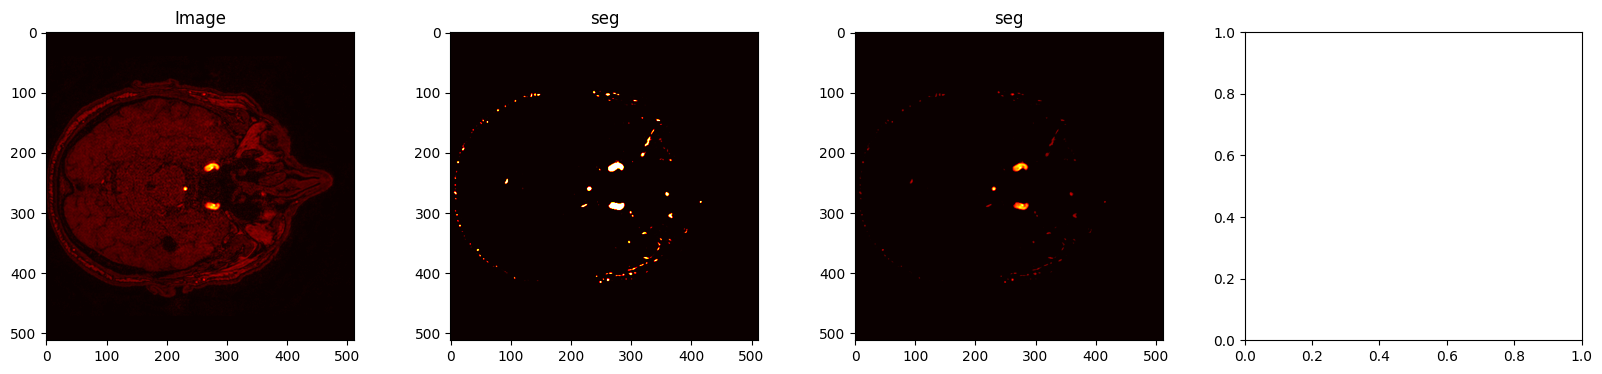

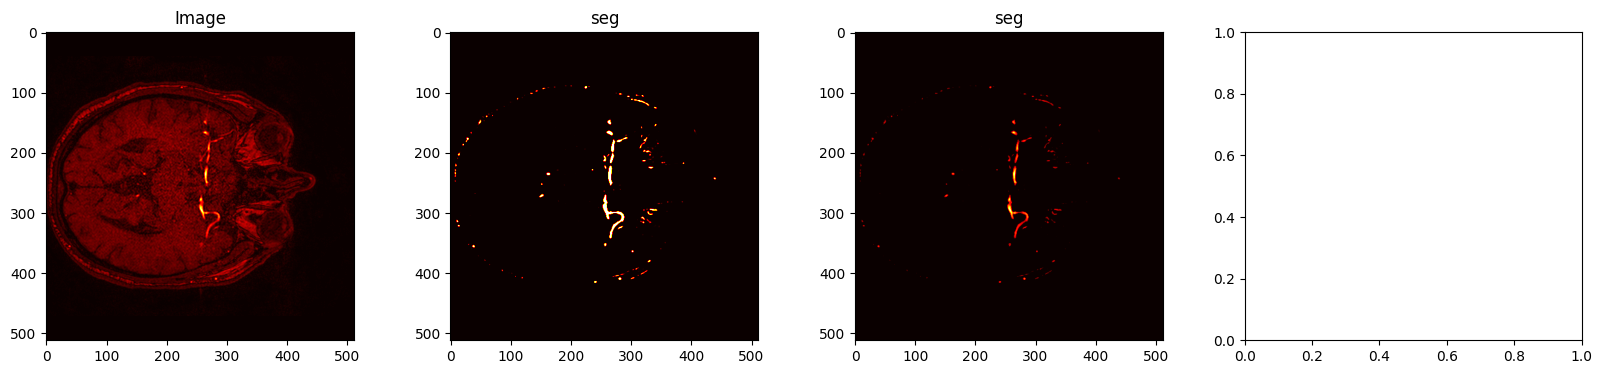

In [17]:
vol_show = vol.detach().numpy()[0, 0]
seg_show = seg.detach().numpy()[0, 0]
#GT_show = GT.detach().numpy()[0, 0]
#filter_2016_show = filter_2016.detach().numpy()[0, 0]

cmap = 'hot'
for idx in range(10, 50, 20):    
    SHOW_SLICE = idx

    fig, ax = plt.subplots(1, 4, figsize=(20, 4))    
    print_img(vol_show, ax[0], slice_=idx, title='Image', cmap=cmap, bar=0)  
    print_img(seg_show, ax[1], slice_=idx, title=f'seg', cmap=cmap, bar=0) 
    print_img(seg_show*vol_ref, ax[2], slice_=idx, title=f'seg', cmap=cmap, bar=0) 
    #print_img(GT_show, ax[3], slice_=idx, title=f'GT', cmap=cmap, bar=0) 
    #print_img(filter_2016_show, ax[3], slice_=idx, title=f'filter_2016', cmap=cmap, bar=0) 
    

In [26]:
from datetime import datetime
dt_string = datetime.now().strftime("%d_%m_%Y_%H:%M")

path_to_save = f"/home/msst/IXI_MRA_work/IXI{sample_index}/nn_out_{dt_string}.nii.gz"
path_to_save_mult = f"/home/msst/IXI_MRA_work/IXI{sample_index}/nn_out_{dt_string}_mult.nii.gz"

save_vol_as_nii(seg_show, vol_file.affine, path_to_save)
save_vol_as_nii(seg_show*vol_ref, vol_file.affine, path_to_save_mult)

In [43]:
# path_to_save_filt = f"/home/msst/TEST/IXI115/filt2016.nii.gz"
# path_to_save_filt_mult = f"/home/msst/TEST/IXI115/filt2016_mult.nii.gz"
# save_vol_as_nii(filter_2016_show, vol_file.affine, path_to_save_filt)
# save_vol_as_nii(filter_2016_show*vol_ref, vol_file.affine, path_to_save_filt_mult)